In [ ]:
# upload kaggle.json file from your machine
from google.colab import files
files.upload()

{}



```
# This is formatted as code
```

## Download dataset

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

 99% 1.20G/1.21G [00:04<00:00, 275MB/s]
100% 1.21G/1.21G [00:05<00:00, 260MB/s]


In [ ]:
!mkdir dataset
!unzip -qq /content/gtzan-dataset-music-genre-classification.zip -d dataset

## Analyze data

In [ ]:
from keras import Sequential
from keras.layers import Dense, Conv2D, Flatten,\
                                Dropout, Rescaling, MaxPooling2D,\
                                BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
datagen = ImageDataGenerator().flow_from_directory("/content/dataset/Data/images_original")

class_count = {}
for label in datagen.classes:
    if label in class_count.keys():
        class_count[label] += 1
    else:
        class_count[label] = 0

print(class_count)

Found 999 images belonging to 10 classes.
{0: 99, 1: 99, 2: 99, 3: 99, 4: 99, 5: 98, 6: 99, 7: 99, 8: 99, 9: 99}


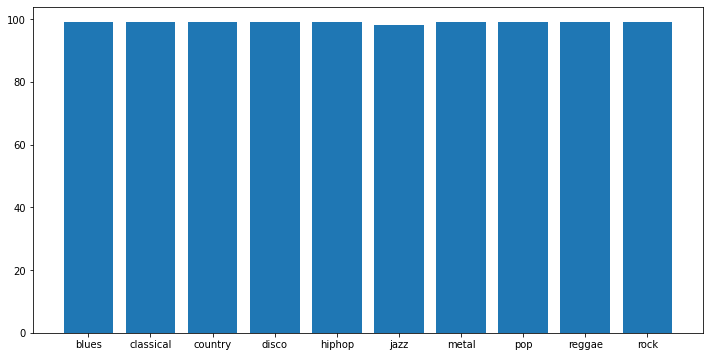

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(datagen.class_indices.keys(), class_count.values());

In [ ]:
datagen.image_shape

(256, 256, 3)

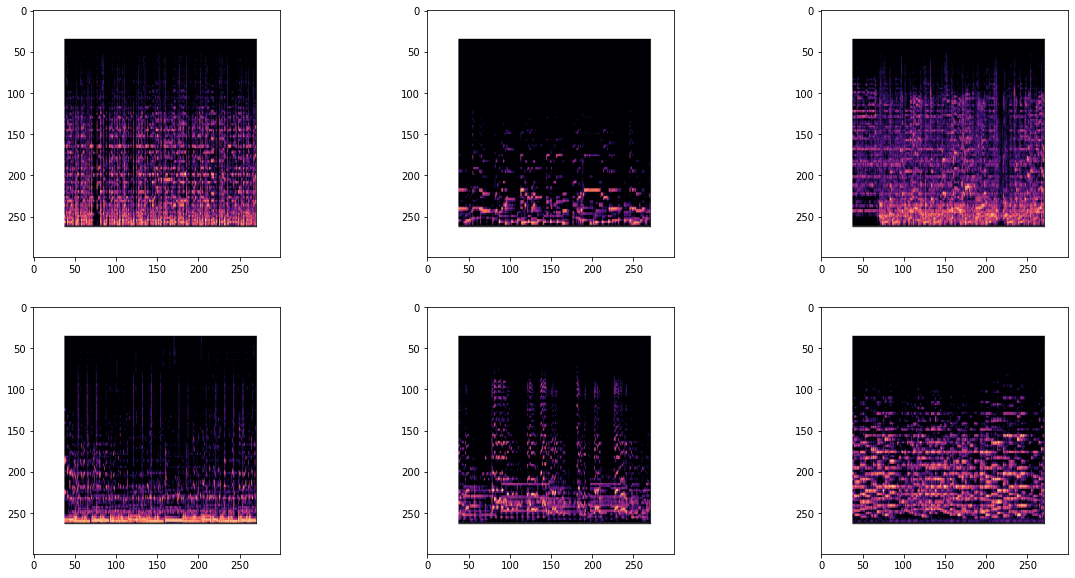

In [ ]:
samples = []
count = 6


for c, sample in enumerate(datagen):
    samples.append(sample)
    if c == count: break

Tot = 6
Cols = 3

Rows = Tot // Cols

if Tot % Cols != 0:
    Rows += 1

Position = range(1,Tot + 1)


fig = plt.figure(figsize=(20, 10))
for k in range(Tot):
  ax = fig.add_subplot(Rows,Cols,Position[k])
  ax.imshow(samples[k][0][0])

plt.show()

## Prepare dataset

In [ ]:
datagen = ImageDataGenerator(rescale=1./255.0, validation_split=0.2)
train_datagen = datagen.flow_from_directory(
    "/content/dataset/Data/images_original",
    target_size=(300,300),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
)

valid_datagen = datagen.flow_from_directory(
    "/content/dataset/Data/images_original",
    target_size=(300,300),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
)

Found 800 images belonging to 10 classes.
Found 199 images belonging to 10 classes.


## Train

In [ ]:
# transfer learning
from tensorflow.keras.applications import VGG19
vgg_layer = VGG19(include_top=False,input_shape=(300, 300, 3))

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
model = Sequential([
    vgg_layer,
    Flatten(),
    Dropout(.5),
    Dense(256, 'relu'),
    Dropout(.3),
    Dense(64, 'relu'),
    Dense(10, 'softmax')
])
model.layers[0].trainable=False
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 9, 9, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 41472)             0         
                                                                 
 dropout_2 (Dropout)         (None, 41472)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               10617088  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 10)               

In [ ]:
history = model.fit(
    train_datagen,
    validation_data = valid_datagen,
    epochs=40,
)

Epoch 1/40
25/25 [==============================] - 13s 500ms/step - loss: 2.9791 - accuracy: 0.1513 - val_loss: 1.9084 - val_accuracy: 0.3467
Epoch 2/40
25/25 [==============================] - 12s 469ms/step - loss: 1.9871 - accuracy: 0.2750 - val_loss: 1.7428 - val_accuracy: 0.5176
Epoch 3/40
25/25 [==============================] - 12s 465ms/step - loss: 1.7892 - accuracy: 0.3475 - val_loss: 1.6593 - val_accuracy: 0.4070
Epoch 4/40
25/25 [==============================] - 11s 455ms/step - loss: 1.6287 - accuracy: 0.3988 - val_loss: 1.5435 - val_accuracy: 0.5528
Epoch 5/40
25/25 [==============================] - 11s 449ms/step - loss: 1.5173 - accuracy: 0.4588 - val_loss: 1.3990 - val_accuracy: 0.5628
Epoch 6/40
25/25 [==============================] - 11s 455ms/step - loss: 1.4057 - accuracy: 0.4988 - val_loss: 1.4276 - val_accuracy: 0.5226
Epoch 7/40
25/25 [==============================] - 11s 448ms/step - loss: 1.3457 - accuracy: 0.5213 - val_loss: 1.3281 - val_accuracy: 0.5477

## Evaluate

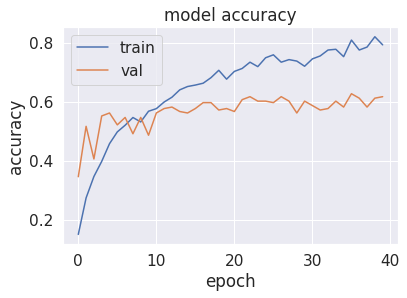

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left');

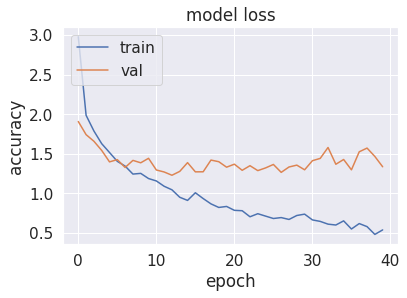

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left');

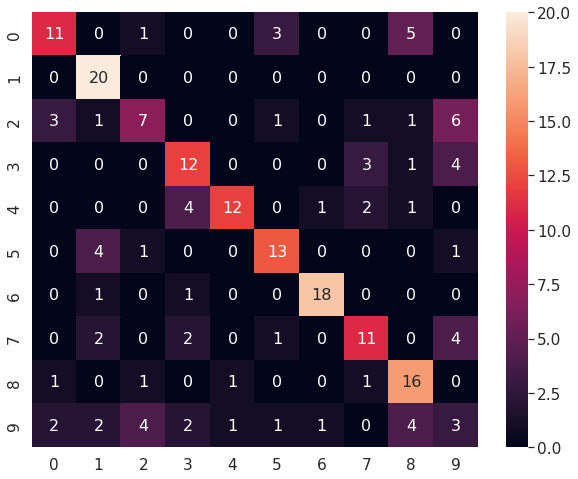

In [ ]:
y_pred = model.predict(valid_datagen)
y_pred = [np.argmax(y) for y in y_pred]

cm = confusion_matrix(valid_datagen.classes, y_pred)

plt.figure(figsize=(10, 8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16}); # font size